In [ ]:
# 必要なライブラリをインストール
! pip install jijmodeling ommx ommx_pyscipopt_adapter ommx_python_mip_adapter deap matplotlib

# 使用する数理モデルの定式化

In [4]:
import jijmodeling as jm
from ommx_pyscipopt_adapter import instance_to_model, model_to_solution
from ommx.v1 import Instance, Solution
import time
import numpy as np


class Solver:
    def __init__(self):
        # Problem parameters
        p = jm.Placeholder("p", ndim=1, description="Profit values for each item")
        w = jm.Placeholder(
            "w",
            ndim=2,
            description="Weight matrix where w[m,i] is weight of item i in constraint m",
        )
        c = jm.Placeholder(
            "c", ndim=1, description="Capacity constraints for each dimension"
        )

        # Get dimensions from placeholders with latex representation
        N = p.len_at(0, latex="N")  # Number of items from length of profit array
        M = w.len_at(
            0, latex="M"
        )  # Number of constraints from first dimension of weight matrix

        # Indices
        i = jm.Element("i", (0, N), description="Item index")
        m = jm.Element("m", (0, M), description="Constraint index")

        # Decision variables
        x = jm.BinaryVar(
            "x", shape=(N,), description="Binary decision variable for item selection"
        )

        # Problem definition
        problem = jm.Problem("MultiConstrainedKnapsack", sense=jm.ProblemSense.MAXIMIZE)

        # Objective: Maximize total profit
        problem += jm.sum(i, p[i] * x[i])

        # Constraints: Weight constraints for each dimension
        problem += jm.Constraint(
            "capacity_constraints", jm.sum(i, w[m, i] * x[i]) <= c[m], forall=m
        )
        self.problem = problem

    def solve(self, p, w, c):
        # Create instance data
        instance_data = {"p": p, "w": w, "c": c}

        # Create interpreter and evaluate problem
        interpreter = jm.Interpreter(instance_data)
        instance: Instance = interpreter.eval_problem(self.problem)
        # PySCIPOpt model に変換
        model = instance_to_model(instance)
        # PySCIPOptのオプションを指定
        model.hideOutput(True)
        model.setParam("limits/time", 60)
        # 求解
        start = time.time()
        model.optimize()
        elapsed_time = time.time() - start
        # 解を取得し、`ommx.v1.Solution`に変換
        solution: Solution = model_to_solution(model, instance)
        # 経過時間と目的関数値を返す
        return elapsed_time, solution.objective

In [2]:
solver = Solver()
solver.problem

# ランダムなインスタンス生成

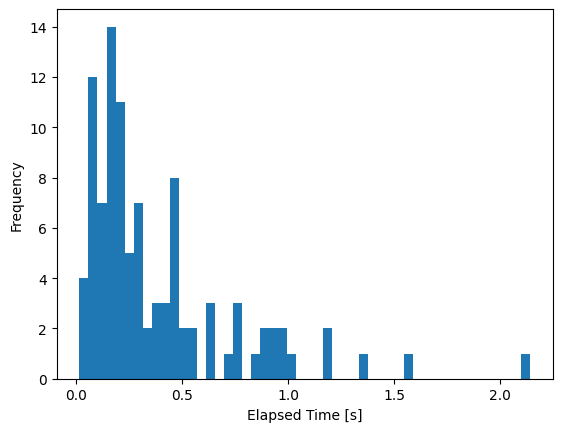

In [3]:
import numpy as np

N = 100
M = 10
p_lower = 1
p_upper = 999
w_lower = 1
w_upper = 999
c_lower = 10000
c_upper = 20000

s = Solver()
elapsed_times = []

for _ in range(100):
    instance_data = {
        "p": np.random.randint(p_lower, p_upper, size=(N), dtype=np.int32).tolist(),
        "w": np.random.randint(w_lower, w_upper, size=(M, N), dtype=np.int32).tolist(),
        "c": np.random.randint(c_lower, c_upper, size=(M), dtype=np.int32).tolist(),
    }

    elapsed_time, _ = s.solve(
        instance_data["p"], instance_data["w"], instance_data["c"]
    )
    elapsed_times.append(elapsed_time)

# Draw Histogram
import matplotlib.pyplot as plt

plt.hist(elapsed_times, bins=50)
plt.xlabel("Elapsed Time [s]")
plt.ylabel("Frequency")
plt.show()

# 遺伝的アルゴリズムの実装

In [5]:
from deap import base, creator, tools, algorithms
import random

# 行列のサイズ
N = 100
M = 10
matrix_sizes = {
    "p": (N, 1),  # Nx1 行列
    "w": (M, N),  # MxN 行列
    "c": (M, 1),  # Mx1 行列
}

# 個体の1次元ベクトル化のための長さ
p_size = np.prod(matrix_sizes["p"])
w_size = np.prod(matrix_sizes["w"])
c_size = np.prod(matrix_sizes["c"])

total_length = p_size + w_size + c_size


# 評価関数
def evaluate(individual):
    # 1次元ベクトルを行列に復元
    p_size = np.prod(matrix_sizes["p"])
    w_size = np.prod(matrix_sizes["w"])
    c_size = np.prod(matrix_sizes["c"])

    p = np.array(individual[:p_size]).reshape(matrix_sizes["p"]).reshape(N).tolist()
    w = (
        np.array(individual[p_size : p_size + w_size])
        .reshape(matrix_sizes["w"])
        .tolist()
    )
    c = (
        np.array(individual[p_size + w_size :])
        .reshape(matrix_sizes["c"])
        .reshape(M)
        .tolist()
    )

    # 問題を解く
    elapsed_time, _ = s.solve(p, w, c)

    return (elapsed_time,)


# DEAPのセットアップ
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # 難解度を最大化
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()


# 個体の生成
# 個体生成時の属性をカスタマイズ
def custom_individual():
    # p と w を範囲 [1, 999] で生成
    p_values = [random.uniform(1, 999) for _ in range(p_size)]
    w_values = [random.uniform(1, 999) for _ in range(w_size)]
    # c を範囲 [20000, 40000] で生成
    c_values = [random.uniform(10000, 20000) for _ in range(c_size)]
    return p_values + w_values + c_values


toolbox.register("individual", tools.initIterate, creator.Individual, custom_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 遺伝的操作
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # 2点交叉
toolbox.register(
    "mutate", tools.mutGaussian, mu=0, sigma=50, indpb=20
)  # ガウス分布による突然変異
toolbox.register("select", tools.selTournament, tournsize=3)  # トーナメント選択


random.seed(42)

# 初期集団の生成
pop = toolbox.population(n=100)  # 集団サイズ (サンプルコードのため、100 -> 10 に変更)

# 統計データの収集
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# 最適化の実行 (サンプルコードのため、世代数を40 -> 4 に変更)
pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=4, stats=stats, verbose=True
)

# 最適解の取得
best_ind = tools.selBest(pop, k=1)[0]
print("Best Individual (flattened):", best_ind)

# 最適解を行列に復元
p_size = np.prod(matrix_sizes["p"])
w_size = np.prod(matrix_sizes["w"])
c_size = np.prod(matrix_sizes["c"])

best_p = np.array(best_ind[:p_size]).reshape(matrix_sizes["p"])
best_w = np.array(best_ind[p_size : p_size + w_size]).reshape(matrix_sizes["w"])
best_c = np.array(best_ind[p_size + w_size :]).reshape(matrix_sizes["c"])

print("Best P Matrix:\n", best_p)
print("Best W Matrix:\n", best_w)
print("Best C Matrix:\n", best_c)
print("Best Fitness (difficulty):", best_ind.fitness.values[0])

gen	nevals	avg     	std     	min       	max    
0  	100   	0.341571	0.320261	0.00820827	1.62875
1  	68    	0.568216	0.462615	0.065393  	1.92893
2  	63    	0.816084	0.589539	0.0457261 	2.75469
3  	68    	0.984964	0.586792	0.071202  	2.75469
4  	65    	1.24875 	0.776342	0.100046  	2.78846
Best Individual (flattened): [32.84416948467965, 836.6018381784552, 840.6754785405606, 892.5101066159555, 385.95119946272064, 214.02783226995203, 573.7991494756693, 645.8551630947395, 541.8371119829831, 1019.3978127374587, 822.8794410118115, 393.055158244966, 950.7056263877186, 749.4286192580902, 642.1978646633764, 248.12524220967816, 977.7245293715972, 718.8616702041352, 892.25590675238, -33.46801979001616, 651.5974586134968, 930.1169934619907, 313.8975585893865, 761.6952647573341, 967.2449073855561, 777.9048588749124, 326.03517282584284, 602.1598161966087, 192.2454335508149, 659.5901730700703, 762.052510008582, 685.7506874600978, 833.2452628676211, 99.18992825049527, -58.3307217719053, -53.01398240224

# SCIPで20秒かかるインスタンスの取得

In [1]:
from ommx.artifact import Artifact

artifact = Artifact.load(
    "ghcr.io/j-i-k-o/2024_adventcalendar/multiconstraint_knapsack_20s:20241221_0928"
)
print(artifact.image_name)

ghcr.io/j-i-k-o/2024_adventcalendar/multiconstraint_knapsack_20s:20241221_0928


In [6]:
# get instance
desc = artifact.get_layer_descriptor(artifact.layers[0].digest)
instance = artifact.get_instance(desc)

## PySCIPOptを用いて求解

In [ ]:
# PySCIPOpt model に変換
model = instance_to_model(instance)
# PySCIPOptのオプションを指定
model.hideOutput(False)
model.redirectOutput()
model.setParam("limits/time", 60)
# 求解
start = time.time()
model.optimize()
elapsed_time = time.time() - start
# 解を取得し、`ommx.v1.Solution`に変換
solution = model_to_solution(model, instance)

feasible solution found by trivial heuristic after 0.0 seconds, objective value 0.000000e+00
presolving:
(round 1, fast)       3 del vars, 0 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.0s) probing: 51/97 (52.6%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (0.0s) no symmetry present (symcode time: 0.00)
presolving (2 rounds: 2 fast, 1 medium, 1 exhaustive):
 3 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 97 variables (97 bin, 0 int, 0 impl, 0 cont) and 10 constraints
     10 constraints of type <linear>
Presolving Time: 0.00
transformed 1/1 original solutions to the transformed problem space

 time | node  

## Python-MIP (CBC)を用いて求解

In [8]:
from ommx_python_mip_adapter import instance_to_model, model_to_solution

# Python-MIP model に変換
model = instance_to_model(instance)
# Python-MIPのオプションを指定
model.verbose = True
# 求解
start = time.time()
model.optimize()
elapsed_time = time.time() - start
# 解を取得し、`ommx.v1.Solution`に変換
solution = model_to_solution(model, instance)

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Feb 27 2024
Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 10 (0) rows, 97 (-3) columns and 970 (-30) elements
Clp1000I sum of infeasibilities 0 - average 0, 87 fixed columns
Coin0506I Presolve 9 (-1) rows, 10 (-87) columns and 90 (-880) elements
Clp0029I End of values pass after 10 iterations
Clp0000I Optimal - objective value 26613.041
Clp0000I Optimal - objective value 26613.041
Coin0511I After Postsolve, objective 26613.041, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 26613.041
Clp0000I Optimal - objective value 26613.041
Clp0000I Optimal - objective value 26613.041
Coin0511I After Postsolve, objective 26613.041, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 26613.04117 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
maxSavedSolutions was changed from 1 to 10
Continuous objectiv